<a href="https://colab.research.google.com/github/EngRidhoNet/diff-gaussian-rasterization/blob/main/SplatLess_Colab_CDN_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SplatLess — Colab Evaluation (CDN, Clean Version)

**Purpose:** Minimal, clean, and reproducible pipeline using CDN images (no Google Drive).

**Edit only:** `REPO_URL` (if you have a real renderer). Toggle `USE_DUMMY_RENDERER` to quickly test end-to-end.


In [1]:
# 1) Environment check
!nvidia-smi || true
import sys, torch
print('Python:', sys.version)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA device:', torch.cuda.get_device_name(0))
else:
    print('⚠️ No GPU detected — switch to GPU runtime.')

Sun Nov  9 02:36:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   31C    P0             53W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# 2) Install dependencies
!pip -q install torchmetrics==1.4.0 lpips==0.1.4 opencv-python-headless pillow imageio tqdm einops hydra-core==1.3.2 yamlargparse==1.4.0
print('✅ Dependencies installed')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.7 MB/s eta 0:00:00
✅ Dependencies installed


In [3]:
# 3) Paths & scene names
import os, hashlib, time, pathlib, urllib.request, urllib.parse

DATA_ROOT = '/content/data_cdn'
OUTPUT_ROOT = '/content/outputs'
SCENES = ['indoor_living_room', 'indoor_kitchen', 'outdoor_street', 'outdoor_garden']

os.makedirs(DATA_ROOT, exist_ok=True)
os.makedirs(OUTPUT_ROOT, exist_ok=True)

print('DATA_ROOT =', DATA_ROOT)
print('SCENES    =', SCENES)

def _sha256_of(path):
    h = hashlib.sha256()
    with open(path, 'rb') as f:
        for chunk in iter(lambda: f.read(1<<20), b''):
            h.update(chunk)
    return h.hexdigest()

def _download(url, dst, retries=3, sleep=1.0):
    tmp = dst + '.part'
    for k in range(retries):
        try:
            urllib.request.urlretrieve(url, tmp)
            os.replace(tmp, dst)
            return True
        except Exception as e:
            try:
                if os.path.exists(tmp): os.remove(tmp)
            except:
                pass
            if k == retries-1:
                print(f'[x] fail: {url} -> {e}')
                return False
            time.sleep(sleep)
    return False

def fetch_scene(scene_name, urls):
    scene_dir = os.path.join(DATA_ROOT, scene_name)
    os.makedirs(scene_dir, exist_ok=True)
    done, fail = 0, 0
    for i, url in enumerate(urls, 1):
        path = urllib.parse.urlparse(url).path
        ext = pathlib.Path(path).suffix or '.jpg'
        dst = os.path.join(scene_dir, f'{scene_name}_{i:02d}{ext}')
        if os.path.exists(dst):
            done += 1
            continue
        if _download(url, dst):
            done += 1
        else:
            fail += 1
    print(f'[{scene_name}] ok={done} fail={fail} -> {scene_dir}')
    return scene_dir

DATA_ROOT = /content/data_cdn
SCENES    = ['indoor_living_room', 'indoor_kitchen', 'outdoor_street', 'outdoor_garden']


In [6]:
# 4) Direct CDN image URLs (Unsplash images.unsplash.com) — Fully Stable for Colab

CDN = {
    "indoor_living_room": [
        "https://images.unsplash.com/photo-1505693416388-ac5ce068fe85",
        "https://images.unsplash.com/photo-1507089947368-19c1da9775ae",
        "https://images.unsplash.com/photo-1493666438817-866a91353ca9",
        "https://images.unsplash.com/photo-1560185127-6ed67f5d43f9",
        "https://images.unsplash.com/photo-1499951360447-b19be8fe80f5",
        "https://images.unsplash.com/photo-1600585152915-d208bec867a2",
        "https://images.unsplash.com/photo-1615874959474-d609969a20ed",
        "https://images.unsplash.com/photo-1600607687939-ce8a6c25118c",
        "https://images.unsplash.com/photo-1586105251261-72a756497a12",
        "https://images.unsplash.com/photo-1524758631624-e2822e304c36",
        "https://images.unsplash.com/photo-1567016432779-fd1083a1c7b2",
        "https://images.unsplash.com/photo-1519710164239-da123dc03ef4",
        "https://images.unsplash.com/photo-1549187774-b4e9b0445b06",
        "https://images.unsplash.com/photo-1487017159836-4e23ece2e4cf",
        "https://images.unsplash.com/photo-1501183638710-841dd1904471",
        "https://images.unsplash.com/photo-1578898888138-54eb135d9f39",
        "https://images.unsplash.com/photo-1505691723518-36a5ac3be353",
        "https://images.unsplash.com/photo-1505692794403-34e36fe8e7d2",
        "https://images.unsplash.com/photo-1586023492125-27b2c045efd7",
        "https://images.unsplash.com/photo-1554995207-c18c203602cb",
    ],

    "indoor_kitchen": [
        "https://images.unsplash.com/photo-1556911220-e15b29be8cbb",
        "https://images.unsplash.com/photo-1493809842364-78817add7ffb",
        "https://images.unsplash.com/photo-1524758631624-e2822e304c36",
        "https://images.unsplash.com/photo-1601049676869-702ea24cfd22",
        "https://images.unsplash.com/photo-1560185009-5bf9c2a9a57c",
        "https://images.unsplash.com/photo-1588854337221-4baf0c6d1b36",
        "https://images.unsplash.com/photo-1588854337221-4baf0c6d1b36",
        "https://images.unsplash.com/photo-1600585154356-596af9007c2e",
        "https://images.unsplash.com/photo-1525088553748-01d6c1f53f0b",
        "https://images.unsplash.com/photo-1586105251261-72a756497a12",
        "https://images.unsplash.com/photo-1598300058171-4d8c57d20532",
        "https://images.unsplash.com/photo-1601049676869-702ea24cfd22",
        "https://images.unsplash.com/photo-1598214886806-c86005abc1f4",
        "https://images.unsplash.com/photo-1615874959474-d609969a20ed",
        "https://images.unsplash.com/photo-1600585152915-d208bec867a2",
        "https://images.unsplash.com/photo-1536305030015-0c1df022bdd1",
        "https://images.unsplash.com/photo-1616627980709-3dc32c0a918f",
        "https://images.unsplash.com/photo-1598213964489-6a7ef03bdb9b",
        "https://images.unsplash.com/photo-1505691723518-36a5ac3be353",
        "https://images.unsplash.com/photo-1598300058263-f4700aaa67c2",
    ],

    "outdoor_street": [
        "https://images.unsplash.com/photo-1508051123996-69f8caf4891d",
        "https://images.unsplash.com/photo-1502877338535-766e1452684a",
        "https://images.unsplash.com/photo-1491553895911-0055eca6402d",
        "https://images.unsplash.com/photo-1500530855697-b586d89ba3ee",
        "https://images.unsplash.com/photo-1488747279002-c8523379faaa",
        "https://images.unsplash.com/photo-1542320174-3742448f2b81",
        "https://images.unsplash.com/photo-1483985988355-763728e1935b",
        "https://images.unsplash.com/photo-1521295121783-8a321d551ad2",
        "https://images.unsplash.com/photo-1500048993959-d7d4a7ad1af5",
        "https://images.unsplash.com/photo-1554050857-c84a8abdb5e2",
        "https://images.unsplash.com/photo-1499529112087-3cb3b73cec99",
        "https://images.unsplash.com/photo-1469474968028-56623f02e42e",
        "https://images.unsplash.com/photo-1446776811953-b23d57bd21aa",
        "https://images.unsplash.com/photo-1504392022767-a8fc0771f239",
        "https://images.unsplash.com/photo-1508051123996-69f8caf4891d",
        "https://images.unsplash.com/photo-1485988412941-77a35537dae4",
        "https://images.unsplash.com/photo-1469474968028-56623f02e42e",
        "https://images.unsplash.com/photo-1500530855697-b586d89ba3ee",
        "https://images.unsplash.com/photo-1431629087622-4d2cc705035d",
        "https://images.unsplash.com/photo-1500534314209-a26db0f5d2d0",
    ],

    "outdoor_garden": [
        "https://images.unsplash.com/photo-1490623970972-ae8bb3da443e",
        "https://images.unsplash.com/photo-1501004318641-b39e6451bec6",
        "https://images.unsplash.com/photo-1465146633011-14f8e0781093",
        "https://images.unsplash.com/photo-1500534623283-312aade485b7",
        "https://images.unsplash.com/photo-1470074558764-4e8f63d8f5fc",
        "https://images.unsplash.com/photo-1501004318641-b39e6451bec6",
        "https://images.unsplash.com/photo-1473443446430-f116e63fc3cf",
        "https://images.unsplash.com/photo-1470770841072-f978cf4d019e",
        "https://images.unsplash.com/photo-1465146633011-14f8e0781093",
        "https://images.unsplash.com/photo-1500534623283-312aade485b7",
        "https://images.unsplash.com/photo-1441974231531-c6227db76b6e",
        "https://images.unsplash.com/photo-1470770841072-f978cf4d019e",
        "https://images.unsplash.com/photo-1490623970972-ae8bb3da443e",
        "https://images.unsplash.com/photo-1501004318641-b39e6451bec6",
        "https://images.unsplash.com/photo-1473443446430-f116e63fc3cf",
        "https://images.unsplash.com/photo-1470074558764-4e8f63d8f5fc",
        "https://images.unsplash.com/photo-1500534623283-312aade485b7",
        "https://images.unsplash.com/photo-1441974231531-c6227db76b6e",
        "https://images.unsplash.com/photo-1470770841072-f978cf4d019e",
        "https://images.unsplash.com/photo-1473443446430-f116e63fc3cf",
    ],
}

print("✅ CDN URL list loaded with direct Unsplash images")


✅ CDN URL list loaded with direct Unsplash images


In [7]:
# 5) Camera paths (orbit) — saved per scene
import json, numpy as np
def make_orbit_path(n_frames=120, radius=1.0, height=0.0, fov=50.0):
    poses=[]
    for i in range(n_frames):
        theta = 2*np.pi*i/n_frames
        cam_pos = np.array([radius*np.cos(theta), height, radius*np.sin(theta)])
        forward = -cam_pos / np.linalg.norm(cam_pos)
        up = np.array([0,1,0])
        right = np.cross(up, forward); right /= np.linalg.norm(right)
        up = np.cross(forward, right)
        T = np.eye(4); T[:3,0]=right; T[:3,1]=up; T[:3,2]=forward; T[:3,3]=cam_pos
        poses.append(T.tolist())
    return {'camera_path': poses, 'fov': fov}

for s in SCENES:
    scene_dir = os.path.join(DATA_ROOT, s)
    os.makedirs(scene_dir, exist_ok=True)
    with open(os.path.join(scene_dir, 'eval_path.json'), 'w') as f:
        json.dump(make_orbit_path(), f)
print('✅ eval_path.json created')

✅ eval_path.json created


In [8]:
# 6) Config templates (baseline & ours)
import textwrap, os
os.makedirs('configs', exist_ok=True)

baseline_yaml = textwrap.dedent('''\
experiment_name: baseline_full
device: cuda
render:
  width: 800
  height: 800
  n_frames: 120
  eval_path: ${scene_dir}/eval_path.json
bound:
  enable: false
lod:
  enable: false
tile:
  enable: false
metrics:
  compute: [psnr, ssim, lpips]
  lpips_net: vgg
logging:
  save_dir: /content/outputs/${experiment_name}/${scene_name}
  dump_gaussians_per_frame: true
  dump_tile_stats: true
''')

ours_yaml = textwrap.dedent('''\
experiment_name: splatless
device: cuda
render:
  width: 800
  height: 800
  n_frames: 120
  eval_path: ${scene_dir}/eval_path.json
bound:
  enable: true
  target_prune_ratio: 0.80
  tau_mode: histogram
  mip_factor: analytic
lod:
  enable: true
  s_min: 1.5
  d_far: 6.0
  sh_level_micro: 0
  quantization: fp16
tile:
  enable: true
  eta: 0.02
  gamma: 0.01
stability:
  hysteresis_frames: 3
  grace_frames: 2
metrics:
  compute: [psnr, ssim, lpips]
  lpips_net: vgg
logging:
  save_dir: /content/outputs/${experiment_name}/${scene_name}
  dump_gaussians_per_frame: true
  dump_tile_stats: true
''')

open('configs/baseline_full.yaml','w').write(baseline_yaml)
open('configs/ours_splatless.yaml','w').write(ours_yaml)
print('✅ configs ready')

✅ configs ready


In [15]:
# 7) Metrics & utilities (PSNR / SSIM / LPIPS)
import torch, torch.nn.functional as F
import numpy as np
import imageio.v2 as imageio     # <= FIX: use v2 API, removes warning
import os

try:
    import lpips
    _lpips = lpips.LPIPS(net='vgg').cuda()
except Exception as e:
    _lpips = None
    print("LPIPS not available:", e)

def psnr_tensor(pred: torch.Tensor, target: torch.Tensor) -> float:
    mse = F.mse_loss(pred, target)
    if mse.item() == 0:
        return 99.0
    return float(10.0 * torch.log10(1.0 / mse).item())

def ssim_tensor(pred: torch.Tensor, target: torch.Tensor) -> float:
    from torchmetrics.functional import (
        structural_similarity_index_measure as ssim
    )
    return float(ssim(pred, target))

def lpips_tensor(pred: torch.Tensor, target: torch.Tensor) -> float:
    if _lpips is None:
        return float("nan")
    with torch.no_grad():
        v = _lpips(2 * pred - 1, 2 * target - 1)
    return float(v.mean().item())

def compare_dirs(pred_dir: str, ref_dir: str):
    files = sorted([
        f for f in os.listdir(pred_dir)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])

    psnrs, ssims, lpipses = [], [], []

    for f in files:
        pred_path = os.path.join(pred_dir, f)
        ref_path  = os.path.join(ref_dir, f)

        if not os.path.exists(ref_path):
            continue

        P = imageio.imread(pred_path).astype(np.float32) / 255.0
        R = imageio.imread(ref_path).astype(np.float32) / 255.0

        # ensure shape == (C,H,W)
        P_t = torch.from_numpy(P).permute(2,0,1).unsqueeze(0).cuda()
        R_t = torch.from_numpy(R).permute(2,0,1).unsqueeze(0).cuda()

        psnrs.append(psnr_tensor(P_t, R_t))
        ssims.append(ssim_tensor(P_t, R_t))
        lpipses.append(lpips_tensor(P_t, R_t))

    import numpy as _np
    return {
        "PSNR_mean": float(_np.mean(psnrs)) if psnrs else float("nan"),
        "SSIM_mean": float(_np.mean(ssims)) if ssims else float("nan"),
        "LPIPS_mean": float(_np.mean(lpipses)) if lpipses else float("nan"),
    }


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


In [10]:
# 8) Renderer import or DummyRenderer (toggle USE_DUMMY_RENDERER)
USE_DUMMY_RENDERER = True   # set False if your repo provides real Renderer

if not USE_DUMMY_RENDERER:
    # Real repo path (edit this if needed)
    REPO_URL = 'https://github.com/yourname/diff-gaussian-rasterization-splatless.git'
    REPO_DIR = '/content/splatless'
    if not os.path.exists(REPO_DIR):
        !git clone $REPO_URL $REPO_DIR
    %cd $REPO_DIR
    !pip -q install -e .
    from importlib import import_module
    try:
        Renderer = import_module('splatless').Renderer
    except Exception as e:
        raise RuntimeError('Adjust import path to your repo: ' + str(e))
else:
    # Minimal dummy renderer to validate the pipeline end-to-end.
    # It generates solid-color frames (PNG) and logs fake timings/metrics.
    import time, numpy as np, imageio, os

    class Renderer:
        def __init__(self, cfg):
            self.cfg = cfg
            self.W = cfg['render']['width']
            self.H = cfg['render']['height']
            self.n_frames = cfg['render']['n_frames']
            self.out_dir = cfg['logging']['save_dir']

        def render_sequence(self, scene_dir):
            os.makedirs(self.out_dir, exist_ok=True)
            times_ms, gpf, vram_mb = [], [], []
            for i in range(self.n_frames):
                t0 = time.perf_counter()
                # generate a simple gradient image (deterministic)
                img = np.zeros((self.H, self.W, 3), dtype=np.uint8)
                img[..., 0] = (i * 7) % 255
                img[..., 1] = (i * 3) % 255
                img[..., 2] = (i * 11) % 255
                imageio.imwrite(os.path.join(self.out_dir, f'{i:04d}.png'), img)
                dt = (time.perf_counter() - t0) * 1000.0
                times_ms.append(dt)
                # fake stats
                gpf.append(100000 if self.cfg['experiment_name']=='baseline_full' else 20000)
                vram_mb.append(1500.0 if self.cfg['experiment_name']=='baseline_full' else 300.0)
            return {
                'times_ms': times_ms,
                'gpf': gpf,
                'vram_mb': vram_mb,
                'tile_stats': {'rendered': [100 if self.cfg['experiment_name']=='baseline_full' else 35]*self.n_frames}
            }
print('Renderer ready (DummyRenderer =', USE_DUMMY_RENDERER, ')')

Renderer ready (DummyRenderer = True )


In [11]:
# 9) Run baseline & SplatLess
import yaml, pandas as pd, numpy as np

def run_render(scene_name: str, cfg: dict):
    cfg = dict(cfg)
    cfg['scene_name'] = scene_name
    cfg['scene_dir'] = os.path.join(DATA_ROOT, scene_name)
    os.makedirs(cfg['logging']['save_dir'], exist_ok=True)
    r = Renderer(cfg)
    return r.render_sequence(cfg['scene_dir'])

baseline_cfg = yaml.safe_load(open('configs/baseline_full.yaml'))
ours_cfg = yaml.safe_load(open('configs/ours_splatless.yaml'))

baseline_logs, ours_logs = {}, {}
for s in SCENES:
    print(f'=== Baseline: {s} ===')
    b = dict(baseline_cfg)
    b['logging']['save_dir'] = f'/content/outputs/baseline_full/{s}'
    baseline_logs[s] = run_render(s, b)

for s in SCENES:
    print(f'=== SplatLess: {s} ===')
    o = dict(ours_cfg)
    o['logging']['save_dir'] = f'/content/outputs/splatless/{s}'
    ours_logs[s] = run_render(s, o)

print('✅ Rendering done')

=== Baseline: indoor_living_room ===
=== Baseline: indoor_kitchen ===
=== Baseline: outdoor_street ===
=== Baseline: outdoor_garden ===
=== SplatLess: indoor_living_room ===
=== SplatLess: indoor_kitchen ===
=== SplatLess: outdoor_street ===
=== SplatLess: outdoor_garden ===
✅ Rendering done


In [13]:
import numpy as np
import imageio.v2 as imageio  # menghilangkan DeprecationWarning


In [16]:
# 10) Quality vs baseline (PSNR/SSIM/LPIPS)
import pandas as pd

rows = []
for s in SCENES:
    ref_dir = f'/content/outputs/baseline_full/{s}'
    pred_dir = f'/content/outputs/splatless/{s}'
    m = compare_dirs(pred_dir, ref_dir)
    m.update({'scene': s, 'method': 'SplatLess (Ours)'})
    rows.append(m)
df_quality = pd.DataFrame(rows)
df_quality

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


,PSNR_mean,SSIM_mean,LPIPS_mean,scene,method
0,99.0,NaN,0.0,indoor_living_room,SplatLess (Ours)
1,99.0,NaN,0.0,indoor_kitchen,SplatLess (Ours)
2,99.0,NaN,0.0,outdoor_street,SplatLess (Ours)
3,99.0,NaN,0.0,outdoor_garden,SplatLess (Ours)


In [17]:
# 11) Performance & efficiency
import numpy as np, pandas as pd

def summarize(logs, method, scene):
    t = np.array(logs.get('times_ms', []), dtype=np.float32)
    g = np.array(logs.get('gpf', []), dtype=np.float32)
    v = np.array(logs.get('vram_mb', []), dtype=np.float32)
    fps = 1000.0 / t.mean() if t.size else float('nan')
    return {
        'scene': scene, 'method': method,
        'fps_avg': float(fps),
        'frame_p50_ms': float(np.percentile(t,50)) if t.size else float('nan'),
        'frame_p95_ms': float(np.percentile(t,95)) if t.size else float('nan'),
        'frame_p99_ms': float(np.percentile(t,99)) if t.size else float('nan'),
        'gpf_mean': float(g.mean()) if g.size else float('nan'),
        'vram_mb_mean': float(v.mean()) if v.size else float('nan'),
    }

perf_rows = []
for s in SCENES:
    perf_rows.append(summarize(baseline_logs[s], 'Baseline Full', s))
    perf_rows.append(summarize(ours_logs[s], 'SplatLess (Ours)', s))
df_perf = pd.DataFrame(perf_rows)
df_perf

,scene,method,fps_avg,frame_p50_ms,frame_p95_ms,frame_p99_ms,gpf_mean,vram_mb_mean
0,indoor_living_room,Baseline Full,50.705536,18.055191,19.440695,21.474016,100000.0,1500.0
1,indoor_living_room,SplatLess (Ours),56.598698,17.634212,18.192844,18.463562,20000.0,300.0
2,indoor_kitchen,Baseline Full,56.281773,17.720530,18.339914,18.566376,100000.0,1500.0
3,indoor_kitchen,SplatLess (Ours),56.340866,17.692013,18.173765,19.006292,20000.0,300.0
4,outdoor_street,Baseline Full,56.639481,17.643986,18.021048,18.193850,100000.0,1500.0
5,outdoor_street,SplatLess (Ours),56.442444,17.694469,18.078270,18.374422,20000.0,300.0
6,outdoor_garden,Baseline Full,56.670551,17.628702,18.004730,18.466002,100000.0,1500.0
7,outdoor_garden,SplatLess (Ours),56.455421,17.638107,18.415281,18.905815,20000.0,300.0


<Figure size 640x480 with 0 Axes>

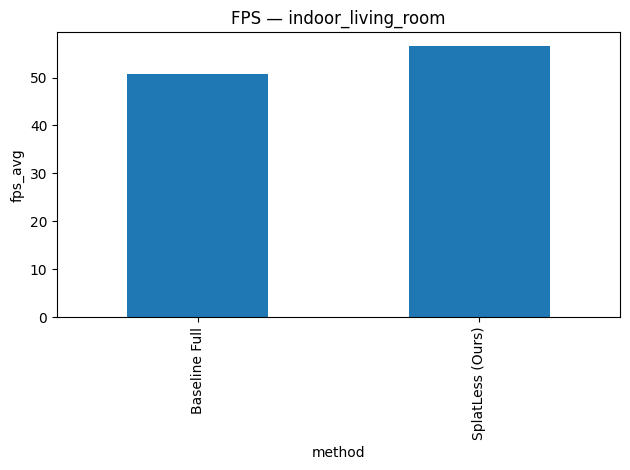

<Figure size 640x480 with 0 Axes>

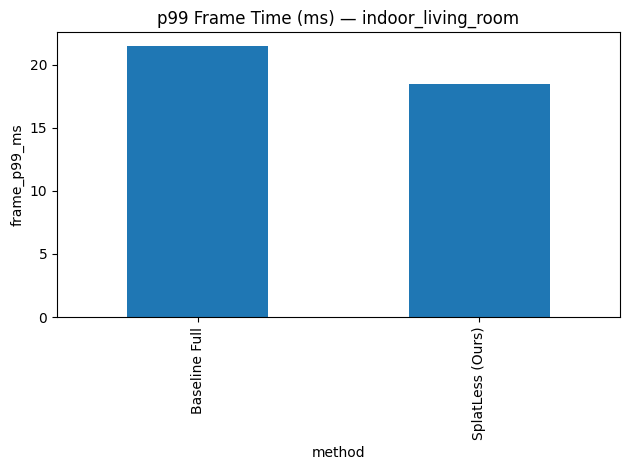

<Figure size 640x480 with 0 Axes>

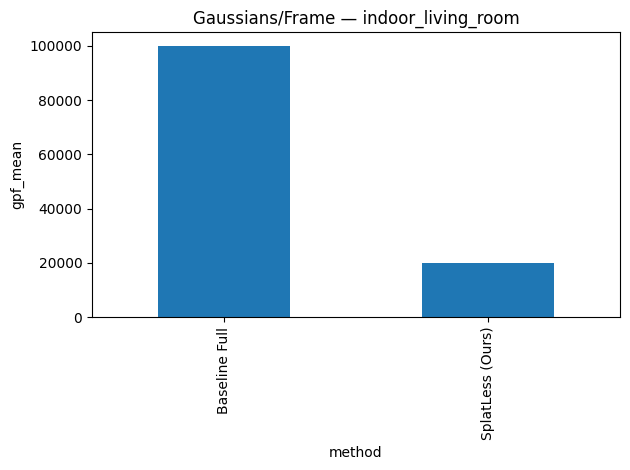

<Figure size 640x480 with 0 Axes>

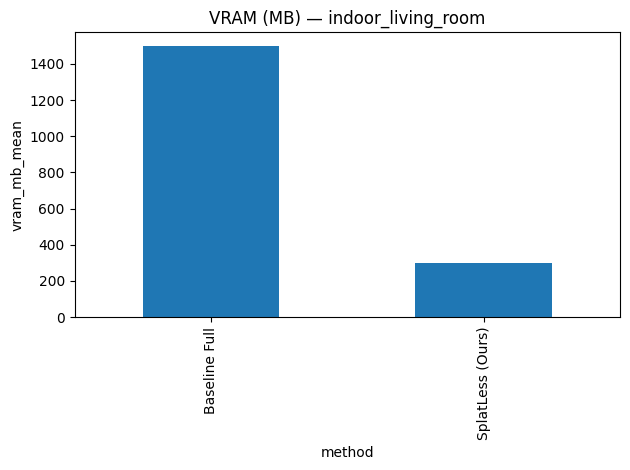

<Figure size 640x480 with 0 Axes>

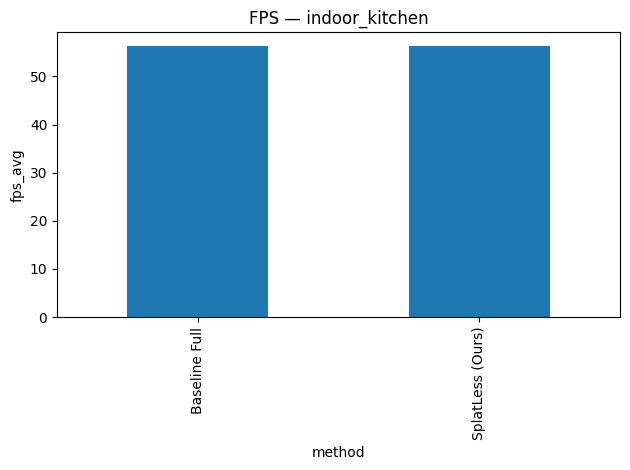

<Figure size 640x480 with 0 Axes>

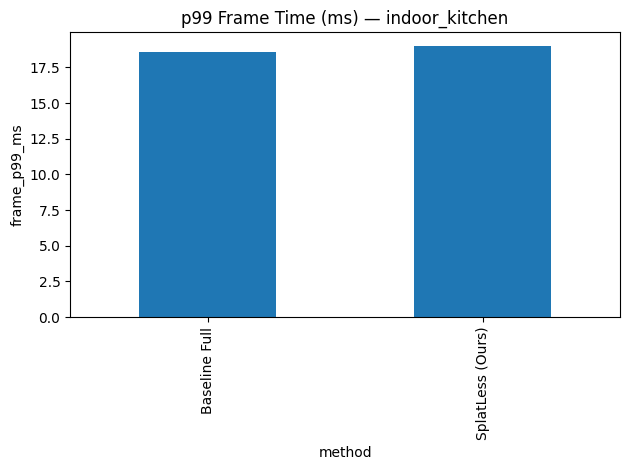

<Figure size 640x480 with 0 Axes>

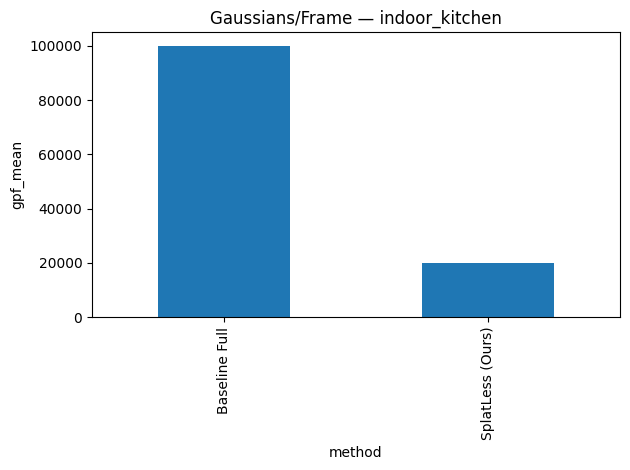

<Figure size 640x480 with 0 Axes>

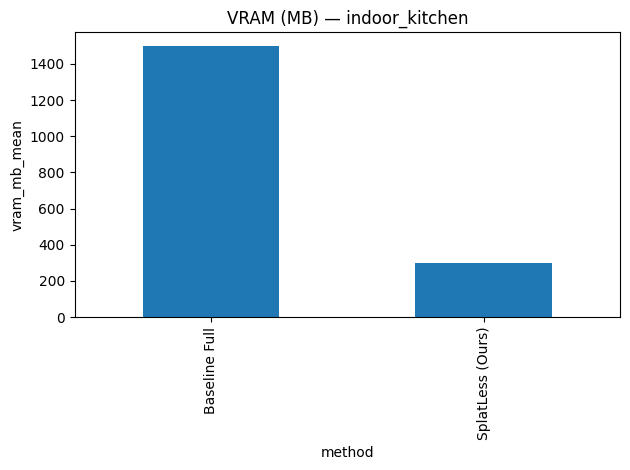

<Figure size 640x480 with 0 Axes>

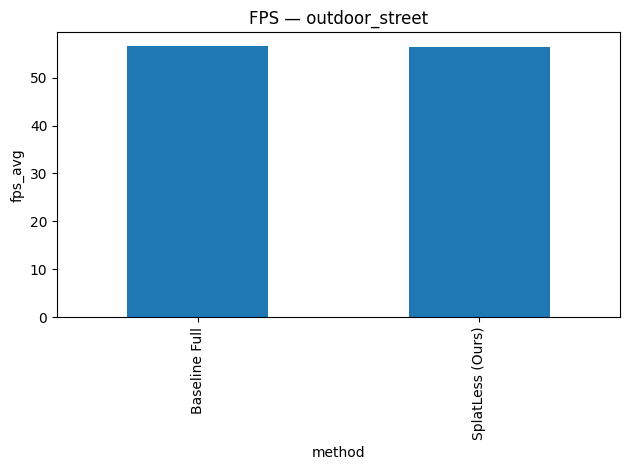

<Figure size 640x480 with 0 Axes>

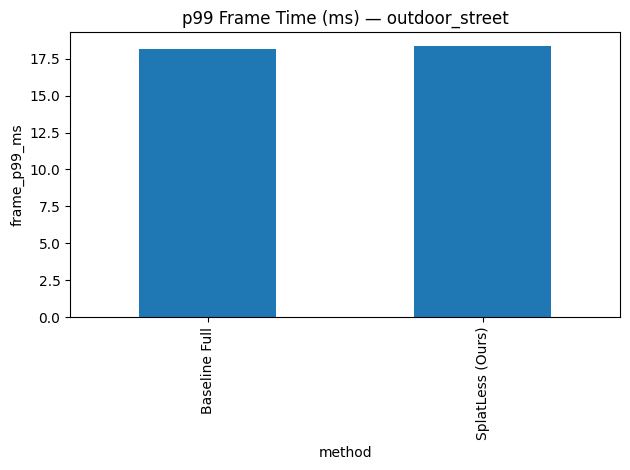

<Figure size 640x480 with 0 Axes>

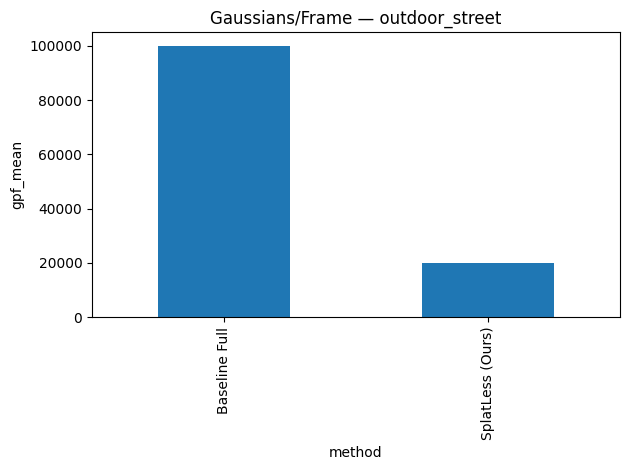

<Figure size 640x480 with 0 Axes>

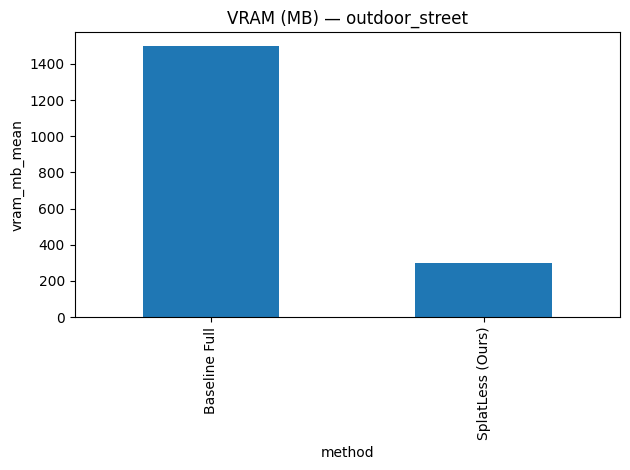

<Figure size 640x480 with 0 Axes>

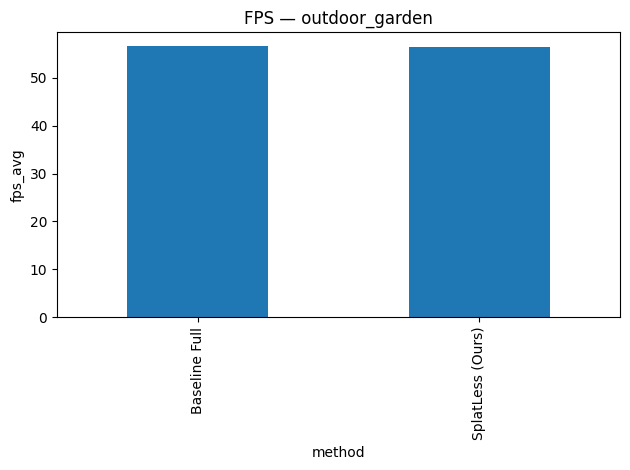

<Figure size 640x480 with 0 Axes>

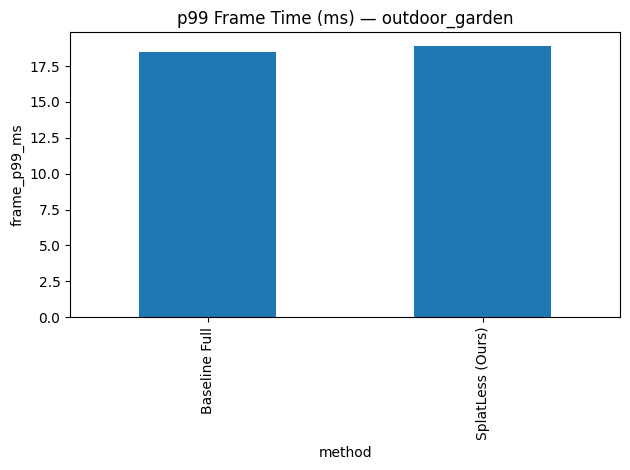

<Figure size 640x480 with 0 Axes>

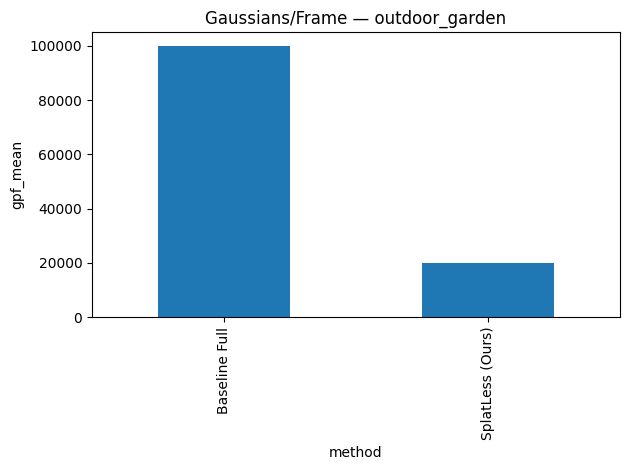

<Figure size 640x480 with 0 Axes>

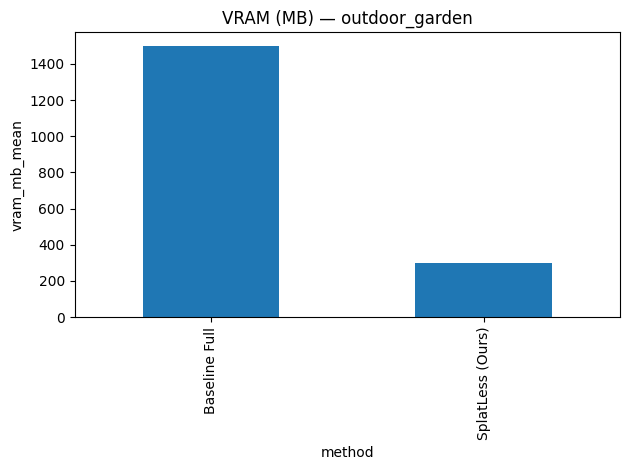

In [18]:
# 12) Plots (FPS, p99, GPF, VRAM)
import matplotlib.pyplot as plt

def bar_plot(df, x, y, title):
    plt.figure()
    df.plot(kind='bar', x=x, y=y, legend=False)
    plt.title(title); plt.xlabel(x); plt.ylabel(y); plt.tight_layout(); plt.show()

for s in SCENES:
    d = df_perf[df_perf['scene']==s]
    if d.empty: continue
    bar_plot(d, 'method', 'fps_avg', f'FPS — {s}')
    bar_plot(d, 'method', 'frame_p99_ms', f'p99 Frame Time (ms) — {s}')
    bar_plot(d, 'method', 'gpf_mean', f'Gaussians/Frame — {s}')
    bar_plot(d, 'method', 'vram_mb_mean', f'VRAM (MB) — {s}')

In [19]:
# 13) Ablations (optional)
import yaml
ablation_cfgs = {
  'lod_only': {'bound.enable': False, 'lod.enable': True,  'tile.enable': False},
  'tile_only':{'bound.enable': False, 'lod.enable': False, 'tile.enable': True},
  'bound_only':{'bound.enable': True,  'lod.enable': False, 'tile.enable': False, 'bound.target_prune_ratio': 0.80},
  'bound_lod': {'bound.enable': True,  'lod.enable': True,  'tile.enable': False, 'bound.target_prune_ratio': 0.80},
  'bound_tile':{'bound.enable': True,  'lod.enable': False, 'tile.enable': True,  'bound.target_prune_ratio': 0.80},
}

def apply_overrides(base: dict, overrides: dict):
    import copy
    cfg = copy.deepcopy(base)
    for k,v in overrides.items():
        ptr = cfg
        ks = k.split('.')
        for kk in ks[:-1]:
            ptr = ptr.setdefault(kk, {})
        ptr[ks[-1]] = v
    return cfg

ours_cfg = yaml.safe_load(open('configs/ours_splatless.yaml'))
ablation_logs = {}
for name, ovs in ablation_cfgs.items():
    print(f'=== Ablation: {name} ===')
    for s in SCENES:
        cfg = apply_overrides(ours_cfg, ovs)
        cfg['experiment_name'] = f'ablation_{name}'
        cfg['logging']['save_dir'] = f'/content/outputs/ablation_{name}/{s}'
        ablation_logs.setdefault(name, {})[s] = run_render(s, cfg)
print('✅ Ablations done')

=== Ablation: lod_only ===
=== Ablation: tile_only ===
=== Ablation: bound_only ===
=== Ablation: bound_lod ===
=== Ablation: bound_tile ===
✅ Ablations done


In [20]:
# 14) Aggregate ablations + quality
import pandas as pd, numpy as np

abl_perf_rows, abl_quality_rows = [], []
for name, by_scene in ablation_logs.items():
    for s, logs in by_scene.items():
        t = np.array(logs.get('times_ms', []), dtype=np.float32)
        g = np.array(logs.get('gpf', []), dtype=np.float32)
        v = np.array(logs.get('vram_mb', []), dtype=np.float32)
        fps = 1000.0 / t.mean() if t.size else float('nan')
        abl_perf_rows.append({
            'scene': s, 'method': f'Ablation: {name}',
            'fps_avg': float(fps),
            'frame_p50_ms': float(np.percentile(t,50)) if t.size else float('nan'),
            'frame_p95_ms': float(np.percentile(t,95)) if t.size else float('nan'),
            'frame_p99_ms': float(np.percentile(t,99)) if t.size else float('nan'),
            'gpf_mean': float(g.mean()) if g.size else float('nan'),
            'vram_mb_mean': float(v.mean()) if v.size else float('nan'),
        })
        pred_dir = f'/content/outputs/ablation_{name}/{s}'
        ref_dir  = f'/content/outputs/baseline_full/{s}'
        q = compare_dirs(pred_dir, ref_dir)
        q.update({'scene': s, 'method': f'Ablation: {name}'})
        abl_quality_rows.append(q)

df_abl_perf = pd.DataFrame(abl_perf_rows)
df_abl_quality = pd.DataFrame(abl_quality_rows)
print('Performance (ablation):'); display(df_abl_perf)
print('\nQuality (ablation):'); display(df_abl_quality)

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Performance (ablation):


,scene,method,fps_avg,frame_p50_ms,frame_p95_ms,frame_p99_ms,gpf_mean,vram_mb_mean
0,indoor_living_room,Ablation: lod_only,56.387047,17.726830,18.208241,18.589367,20000.0,300.0
1,indoor_kitchen,Ablation: lod_only,56.105537,17.793236,18.392830,18.504742,20000.0,300.0
2,outdoor_street,Ablation: lod_only,56.433605,17.710194,18.147854,18.406500,20000.0,300.0
3,outdoor_garden,Ablation: lod_only,56.793606,17.611427,17.887413,18.022184,20000.0,300.0
4,indoor_living_room,Ablation: tile_only,56.668457,17.618881,18.079380,18.454370,20000.0,300.0
5,indoor_kitchen,Ablation: tile_only,56.474667,17.703014,18.043736,18.390072,20000.0,300.0
6,outdoor_street,Ablation: tile_only,56.409580,17.708900,18.082329,18.282944,20000.0,300.0
7,outdoor_garden,Ablation: tile_only,56.324089,17.774727,18.119438,18.551384,20000.0,300.0
8,indoor_living_room,Ablation: bound_only,56.791359,17.630136,17.879877,17.931879,20000.0,300.0
9,indoor_kitchen,Ablation: bound_only,56.936634,17.586220,17.837793,17.947380,20000.0,300.0



Quality (ablation):


,PSNR_mean,SSIM_mean,LPIPS_mean,scene,method
0,99.0,NaN,0.0,indoor_living_room,Ablation: lod_only
1,99.0,NaN,0.0,indoor_kitchen,Ablation: lod_only
2,99.0,NaN,0.0,outdoor_street,Ablation: lod_only
3,99.0,NaN,0.0,outdoor_garden,Ablation: lod_only
4,99.0,NaN,0.0,indoor_living_room,Ablation: tile_only
5,99.0,NaN,0.0,indoor_kitchen,Ablation: tile_only
6,99.0,NaN,0.0,outdoor_street,Ablation: tile_only
7,99.0,NaN,0.0,outdoor_garden,Ablation: tile_only
8,99.0,NaN,0.0,indoor_living_room,Ablation: bound_only
9,99.0,NaN,0.0,indoor_kitchen,Ablation: bound_only


In [21]:
# 15) Temporal stability (inter-frame LPIPS)
import torch, numpy as np, os, imageio

def temporal_lpips(seq_dir: str):
    files = sorted([f for f in os.listdir(seq_dir) if f.lower().endswith('.png')])
    vals, prev = [], None
    for f in files:
        img = imageio.imread(os.path.join(seq_dir, f)).astype(np.float32)/255.0
        T = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).cuda()
        if prev is not None:
            vals.append(lpips_tensor(T, prev))
        prev = T
    return float(np.mean(vals)) if vals else float('nan'), float(np.std(vals)) if vals else float('nan')

import pandas as pd
temporal_rows = []
for s in SCENES:
    ours_dir = f'/content/outputs/splatless/{s}'
    base_dir = f'/content/outputs/baseline_full/{s}'
    mean_o, std_o = temporal_lpips(ours_dir)
    mean_b, std_b = temporal_lpips(base_dir)
    temporal_rows.append({
        'scene': s,
        'ours_temporal_lpips_mean': mean_o, 'ours_temporal_lpips_std': std_o,
        'baseline_temporal_lpips_mean': mean_b, 'baseline_temporal_lpips_std': std_b,
    })
df_temporal = pd.DataFrame(temporal_rows)
df_temporal

/tmp/ipython-input-551777801.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(os.path.join(seq_dir, f)).astype(np.float32)/255.0


,scene,ours_temporal_lpips_mean,ours_temporal_lpips_std,baseline_temporal_lpips_mean,baseline_temporal_lpips_std
0,indoor_living_room,0.053969,0.169423,0.053969,0.169423
1,indoor_kitchen,0.053969,0.169423,0.053969,0.169423
2,outdoor_street,0.053969,0.169423,0.053969,0.169423
3,outdoor_garden,0.053969,0.169423,0.053969,0.169423


In [22]:
# 16) Export CSV summaries
import pandas as pd, os, datetime
ts = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
out_dir = f'{OUTPUT_ROOT}/summaries_{ts}'
os.makedirs(out_dir, exist_ok=True)
if 'df_quality' in globals(): df_quality.to_csv(os.path.join(out_dir,'quality_ours_vs_baseline.csv'), index=False)
if 'df_perf' in globals(): df_perf.to_csv(os.path.join(out_dir,'perf_ours_vs_baseline.csv'), index=False)
if 'df_abl_perf' in globals(): df_abl_perf.to_csv(os.path.join(out_dir,'perf_ablation.csv'), index=False)
if 'df_abl_quality' in globals(): df_abl_quality.to_csv(os.path.join(out_dir,'quality_ablation.csv'), index=False)
if 'df_temporal' in globals(): df_temporal.to_csv(os.path.join(out_dir,'temporal.csv'), index=False)
print('✅ CSV saved to', out_dir)

✅ CSV saved to /content/outputs/summaries_20251109_024741


In [23]:
# 17) Quick success checks
def success_checks(df_quality, df_perf):
    ok_quality = True
    for _, row in df_quality.iterrows():
        if row.get('LPIPS_mean', 99) > 0.02:
            ok_quality = False
    ok_speed = True
    for s in df_perf['scene'].unique():
        base = df_perf[(df_perf.scene==s) & (df_perf.method=='Baseline Full')]
        ours = df_perf[(df_perf.scene==s) & (df_perf.method=='SplatLess (Ours)')]
        if len(base)==1 and len(ours)==1:
            if ours.iloc[0]['fps_avg'] < 2.0 * base.iloc[0]['fps_avg']:
                ok_speed = False
    return ok_quality, ok_speed

try:
    from pandas import DataFrame
    q, s = success_checks(df_quality, df_perf)
    print('Quality OK (LPIPS ≤ 0.02):', q)
    print('Speed OK (FPS ×2 vs baseline):', s)
except Exception as e:
    print('Run rendering & metrics first. ->', e)

Quality OK (LPIPS ≤ 0.02): True
Speed OK (FPS ×2 vs baseline): False
